In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd

file_path = '/content/drive/MyDrive/ufrn/AMNS/BASE/Breast_cancer.csv'

df = pd.read_csv(file_path)
print(df.head())

   Clump_Thickness  Cell_Size_Uniformity  Cell_Shape_Uniformity  \
0                5                     1                      1   
1                5                     4                      4   
2                3                     1                      1   
3                6                     8                      8   
4                4                     1                      1   

   Marginal_Adhesion  Single_Epi_Cell_Size Bare_Nuclei  Bland_Chromatin  \
0                  1                     2           1                3   
1                  5                     7          10                3   
2                  1                     2           2                3   
3                  1                     3           4                3   
4                  3                     2           1                3   

   Normal_Nucleoli  Mitoses   Class  
0                1        1  benign  
1                2        1  benign  
2                1        1  ben

PCA

In [14]:
# @title
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # 1. Centralizar os dados (subtrair a média)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # 2. Calcular a matriz de covariância
        # rowvar=False indica que as colunas são as variáveis
        cov_matrix = np.cov(X_centered, rowvar=False)

        # 3. Calcular autovetores e autovalores
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # 4. Ordenar autovetores pelos autovalores em ordem decrescente
        # Os autovetores são as colunas da matriz `eigenvectors`
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # 5. Armazenar os `n_components` primeiros autovetores
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        # Centralizar os dados usando a média do treino
        X_centered = X - self.mean

        # Projetar os dados nos componentes
        # (n_samples, n_features) @ (n_features, n_components) -> (n_samples, n_components)
        X_projected = np.dot(X_centered, self.components.T)

        return X_projected

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")

In [16]:
print("Dimensões originais do Iris dataset:", df.shape)

Dimensões originais do Iris dataset: (699, 10)


In [17]:
import numpy as np

df_cleaned = df.replace('?', np.nan)

for col in df_cleaned.columns:
    if col != 'Class':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Drop rows with NaN values (resulting from '?' or other non-numeric entries)
df_cleaned = df_cleaned.dropna()

# Separate features from the target variable if 'Class' exists
# For standardization, we typically only scale the feature columns
X = df_cleaned.drop('Class', axis=1, errors='ignore') # 'errors=ignore' prevents error if 'Class' is not present

# Padronizando as características
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

# A média de cada coluna agora é próxima de 0
print("Média após padronização:", np.mean(df_scaled, axis=0))
# O desvio padrão de cada coluna agora é próximo de 1
print("Desvio padrão após padronização:", np.std(df_scaled, axis=0))

Média após padronização: [ 1.14435873e-16  0.00000000e+00 -6.24195668e-17  4.68146751e-17
 -2.08065223e-17  0.00000000e+00  3.12097834e-17  2.08065223e-17
  3.12097834e-17]
Desvio padrão após padronização: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [18]:
# Instanciar e aplicar o PCA para reduzir de 4 para 2 dimensões
pca_df = PCA(n_components=2)
df_pca = pca_df.fit_transform(df_scaled)

print("Dimensão dos dados após o PCA:", df_pca.shape)

Dimensão dos dados após o PCA: (683, 2)


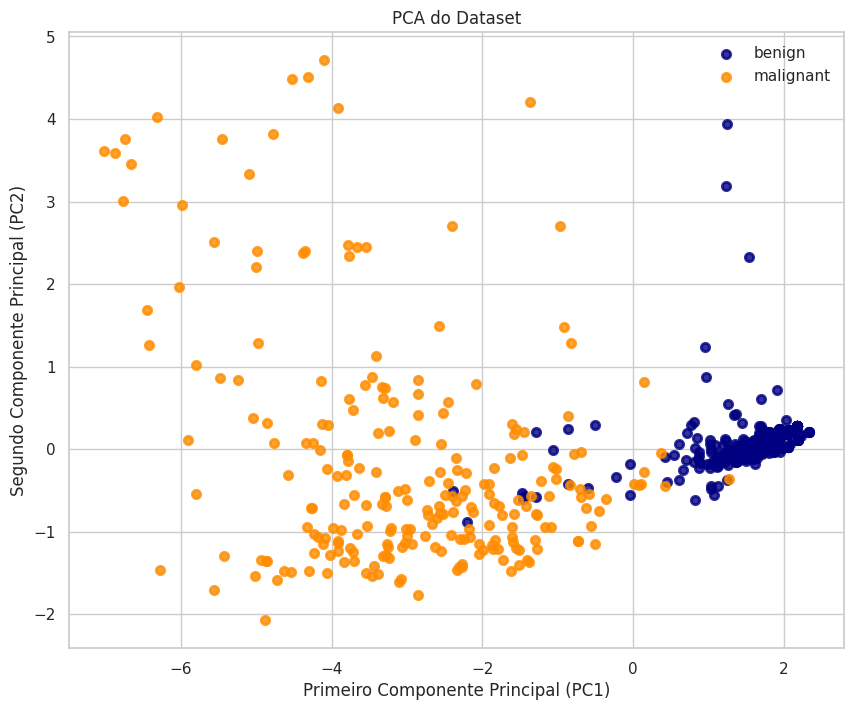

In [19]:
plt.figure(figsize=(10, 8))
target_names = df_cleaned['Class'].unique()
target_names.sort()

colors = ['navy', 'darkorange']

for color, target_name in zip(colors, target_names):
    plt.scatter(df_pca[df_cleaned['Class'] == target_name, 0],
                df_pca[df_cleaned['Class'] == target_name, 1],
                color=color, alpha=.8, lw=2,
                label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA do Dataset')
plt.xlabel('Primeiro Componente Principal (PC1)')
plt.ylabel('Segundo Componente Principal (PC2)')
plt.grid(True)
plt.show()

K_means

In [20]:
# @title
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """
        Inicializa os centróides selecionando K pontos aleatórios do dataset.
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        # Corrected: Use .iloc for integer-location based indexing on DataFrame
        self.centroids = X.iloc[random_indices].values

    def _assign_clusters(self, X):
        """
        Atribui cada ponto de dado ao centróide mais próximo.
        """
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """
        Atualiza a posição de cada centróide com base na média dos pontos atribuídos a ele.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))

        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = self.centroids[i]

        self.centroids = new_centroids

    def fit(self, X):
        """
        Executa o algoritmo K-Means.
        """
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids.copy()
            self._assign_clusters(X)
            self._update_centroids(X)
            if np.allclose(old_centroids, self.centroids):
                break

    def predict(self, X):
        """
        Atribui clusters para novos dados com base nos centróides aprendidos.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        return np.argmin(distances, axis=1)

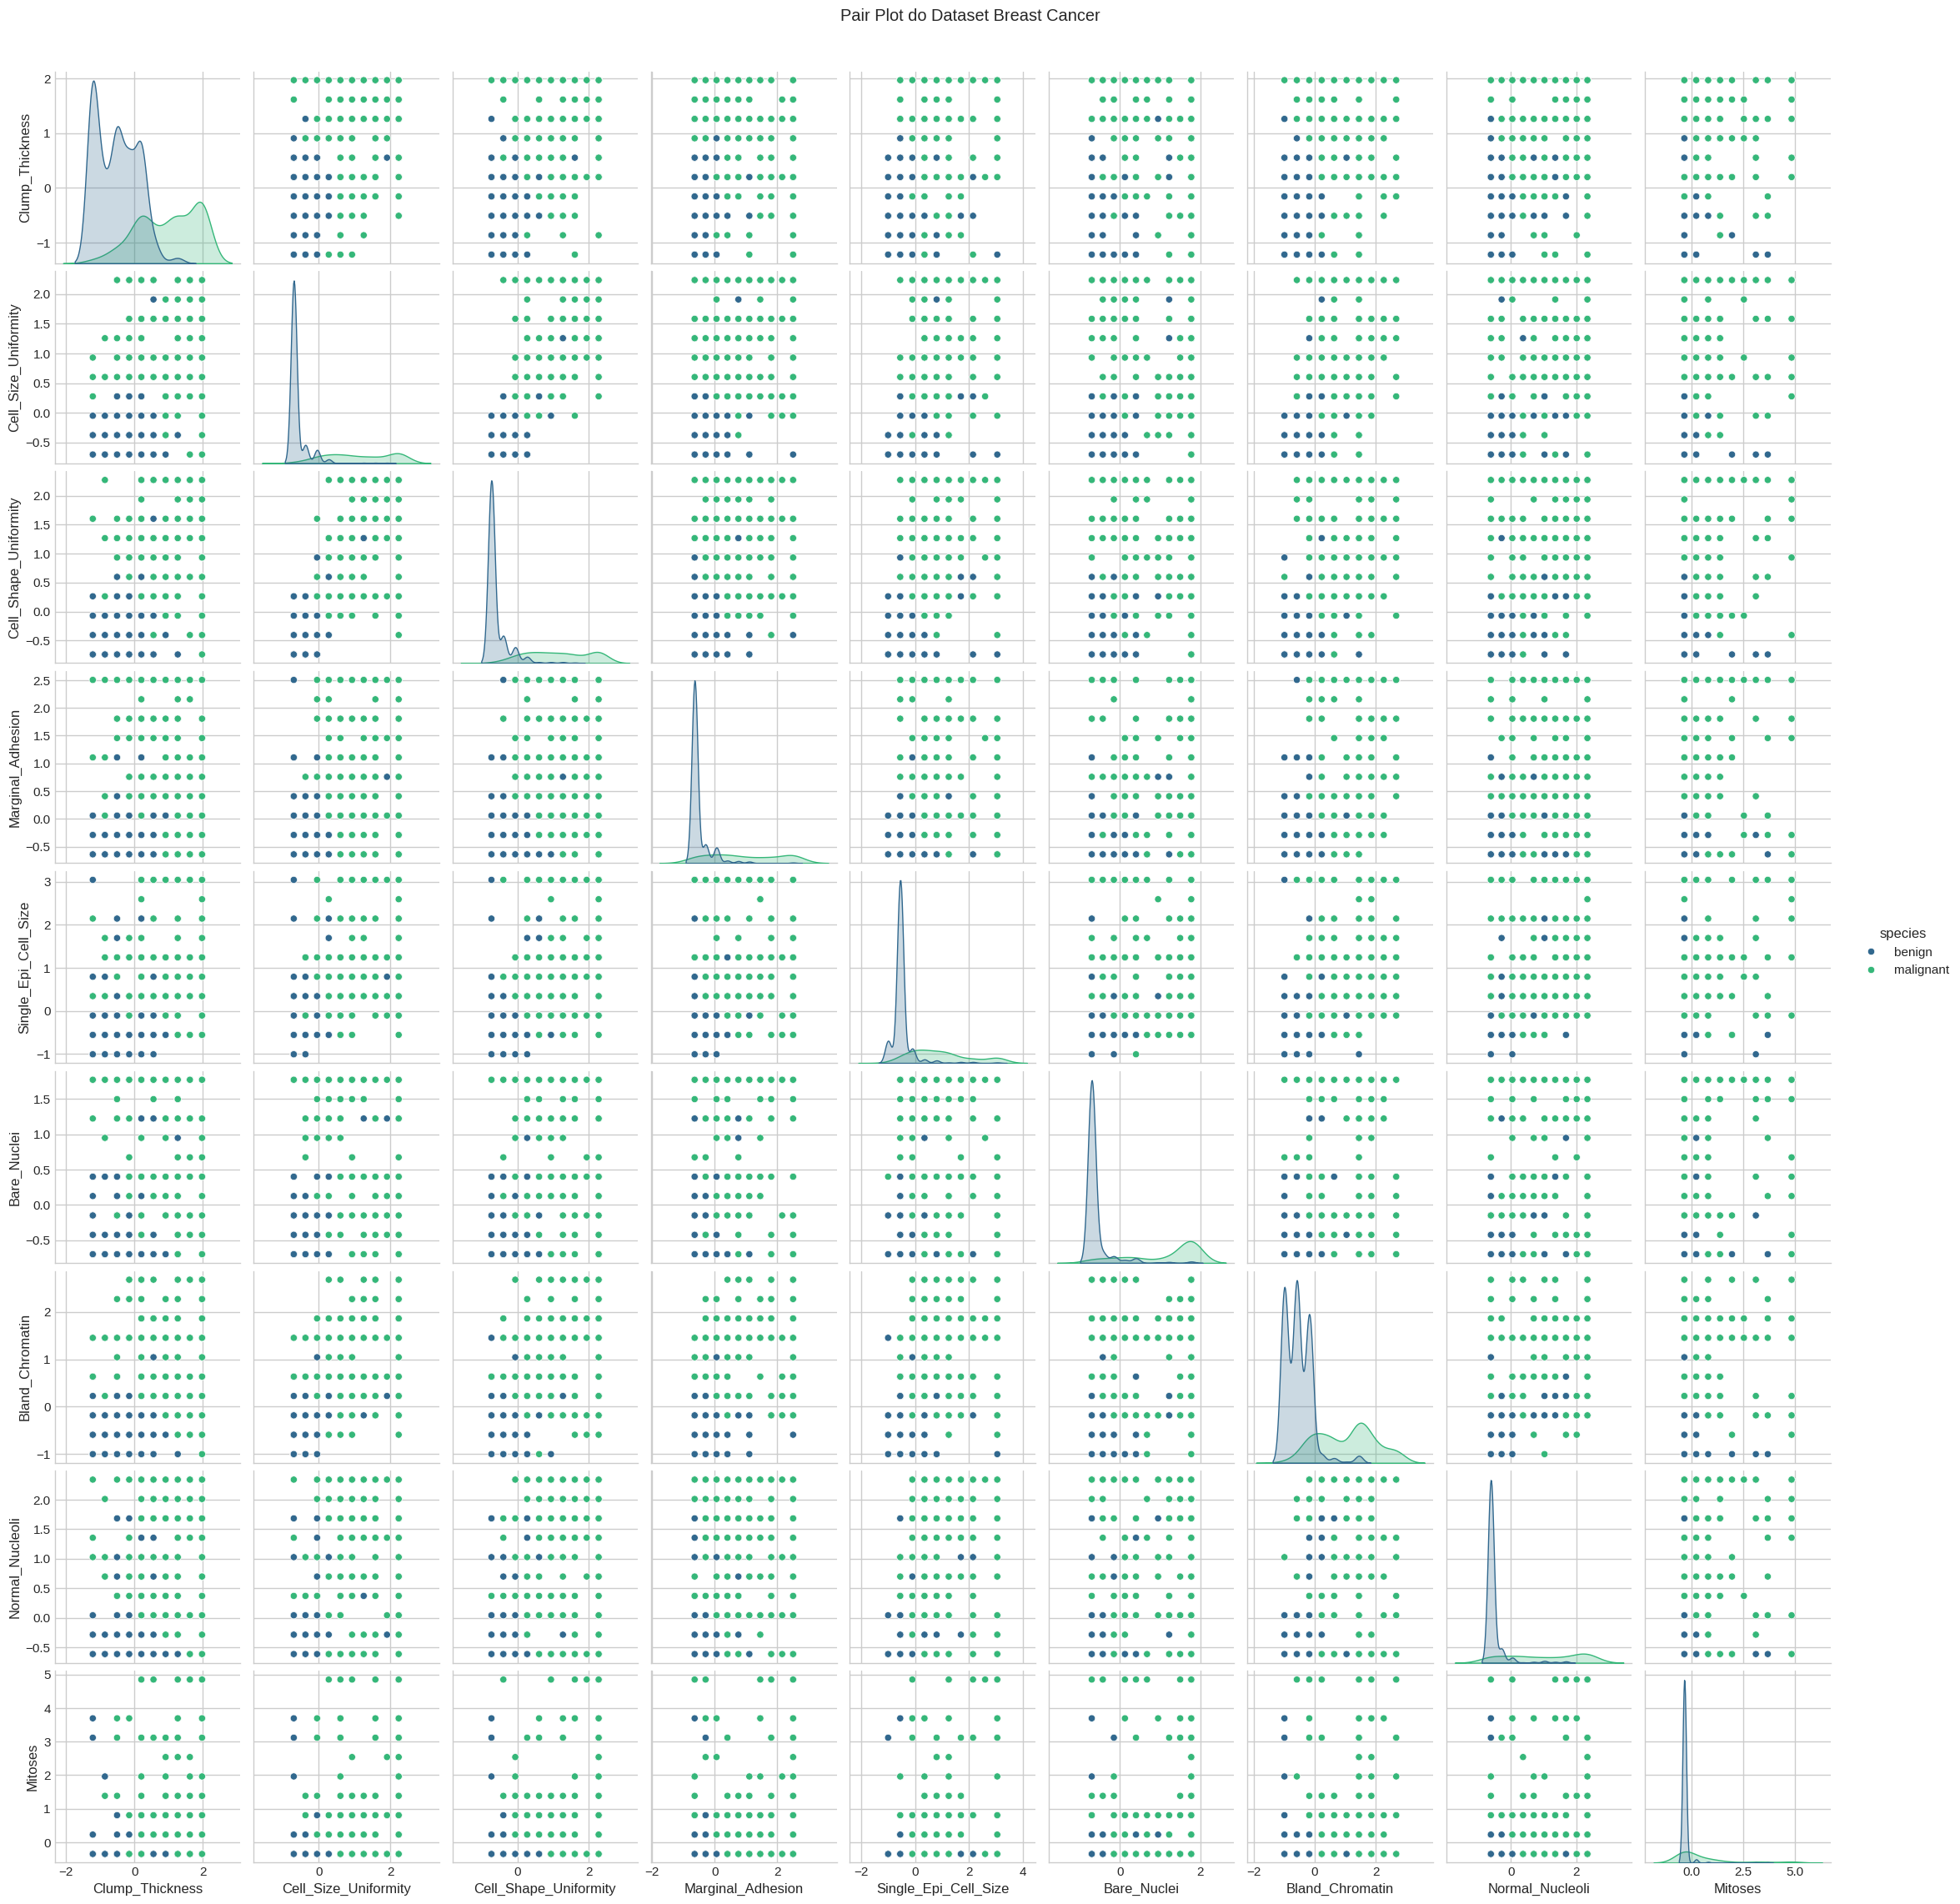

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')

breast_df = pd.DataFrame(df_scaled, columns=X.columns)
breast_df['species'] = df_cleaned['Class'].reset_index(drop=True)

# Plotar o gráfico
sns.pairplot(breast_df, hue='species', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot do Dataset Breast Cancer', y=1.02)
plt.show()

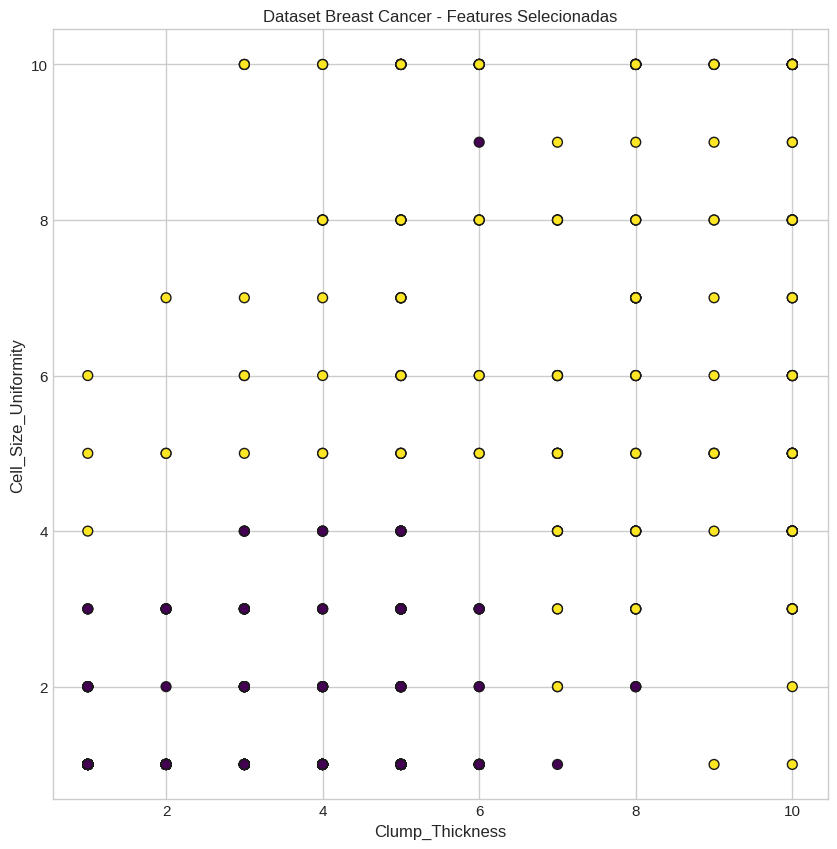

In [22]:
X_selected = X.iloc[:, [0, 1]]
y_true = df_cleaned['Class']

# Plotar o gráfico
plt.figure(figsize=(10, 10))
plt.scatter(X_selected.iloc[:, 0], X_selected.iloc[:, 1], c=y_true.astype('category').cat.codes, cmap='viridis', marker='o', s=50, edgecolor='k')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.title('Dataset Breast Cancer - Features Selecionadas')
plt.show()

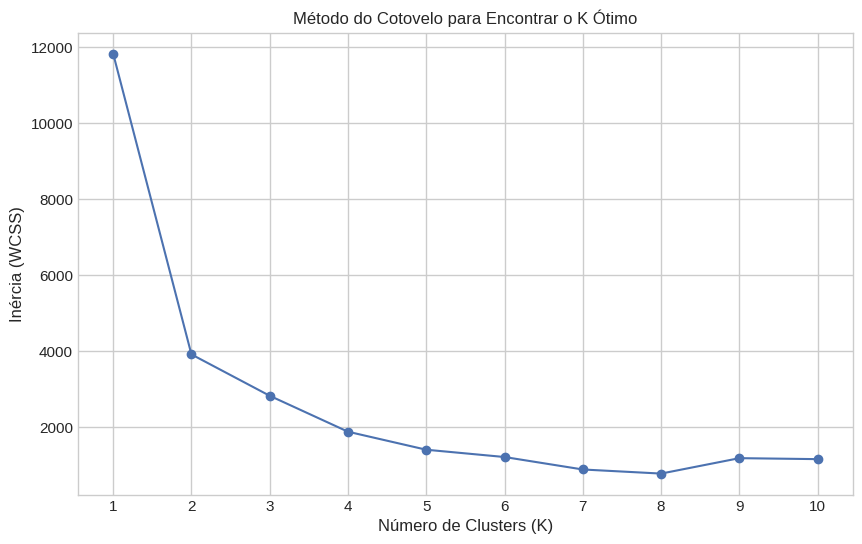

In [23]:
k_range = range(1, 11)
inertias = []

for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42)
    model.fit(X_selected)

    current_inertia = 0.0
    for i in range(k):
        cluster_points = X_selected[model.labels == i]
        if len(cluster_points) > 0:
            current_inertia += np.sum(np.sum((cluster_points - model.centroids[i])**2, axis=1))

    inertias.append(current_inertia)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo para Encontrar o K Ótimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Escolha ideal de K seria 3 ou 4 (ou até mesmo 2), irei optar por 4 por ter mais.

In [24]:
kmeans_breast = KMeans(n_clusters=4, max_iter=150, random_state=42)
kmeans_breast.fit(X_selected)

final_centroids_breast = kmeans_breast.centroids
predicted_labels_breast = kmeans_breast.labels

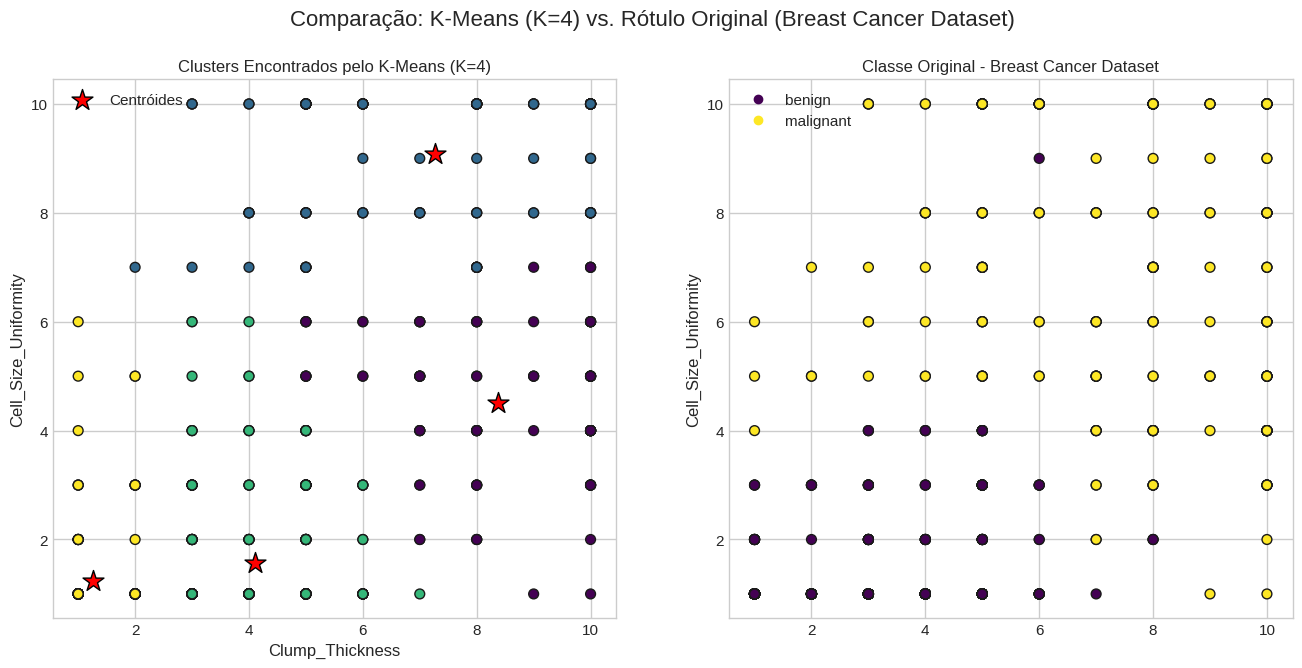

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].scatter(X_selected.iloc[:, 0], X_selected.iloc[:, 1], c=predicted_labels_breast, s=50, cmap='viridis', edgecolor='k')
axes[0].scatter(final_centroids_breast[:, 0], final_centroids_breast[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centróides')
axes[0].set_title('Clusters Encontrados pelo K-Means (K=4)')
axes[0].set_xlabel(X_selected.columns[0])
axes[0].set_ylabel(X_selected.columns[1])
axes[0].legend()
axes[0].grid(True);

scatter = axes[1].scatter(X_selected.iloc[:, 0], X_selected.iloc[:, 1], c=y_true.astype('category').cat.codes, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title('Classe Original - Breast Cancer Dataset')
axes[1].set_ylabel(X_selected.columns[1])
axes[1].legend(handles=scatter.legend_elements()[0], labels=target_names.tolist())
axes[1].grid(True)

plt.suptitle('Comparação: K-Means (K=4) vs. Rótulo Original (Breast Cancer Dataset)', fontsize=16)
plt.show()

In [26]:
from scipy.stats import mode
import numpy as np

correct_predictions_breast = 0
n_samples_breast = X_selected.shape[0]

for i in range(kmeans_breast.n_clusters):
    mask = (predicted_labels_breast == i)

    if np.sum(mask) > 0:
        dominant_label_breast = y_true[mask].mode()[0]

        hits_breast = np.sum(y_true[mask] == dominant_label_breast)

        correct_predictions_breast += hits_breast


print(f"Número de acertos: {correct_predictions_breast} de {n_samples_breast} pontos.")
print(f"Taxa de acerto: {(correct_predictions_breast / n_samples_breast):.2%}")

Número de acertos: 639 de 683 pontos.
Taxa de acerto: 93.56%


Podemos observar que a taxa ficou acima do espera (70%), então o modelo foi bem treinado.

Hierarchical

In [27]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.

        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []

    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist

        return dist_matrix

    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist

        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist

        # elif self.linkage == 'average':
        # Distância média entre todos os pares de pontos dos clusters
        # ...

    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)

        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]

        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)

        self.merge_history = []
        self.distances = []

        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")

        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1

            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j

            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]

            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)

            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")

            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)

            print(f"Clusters restantes: {clusters}\n")

Dataset Breast Cancer:
Shape: (683, 9)
Features: ['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses']
Classes: ['benign', 'malignant']


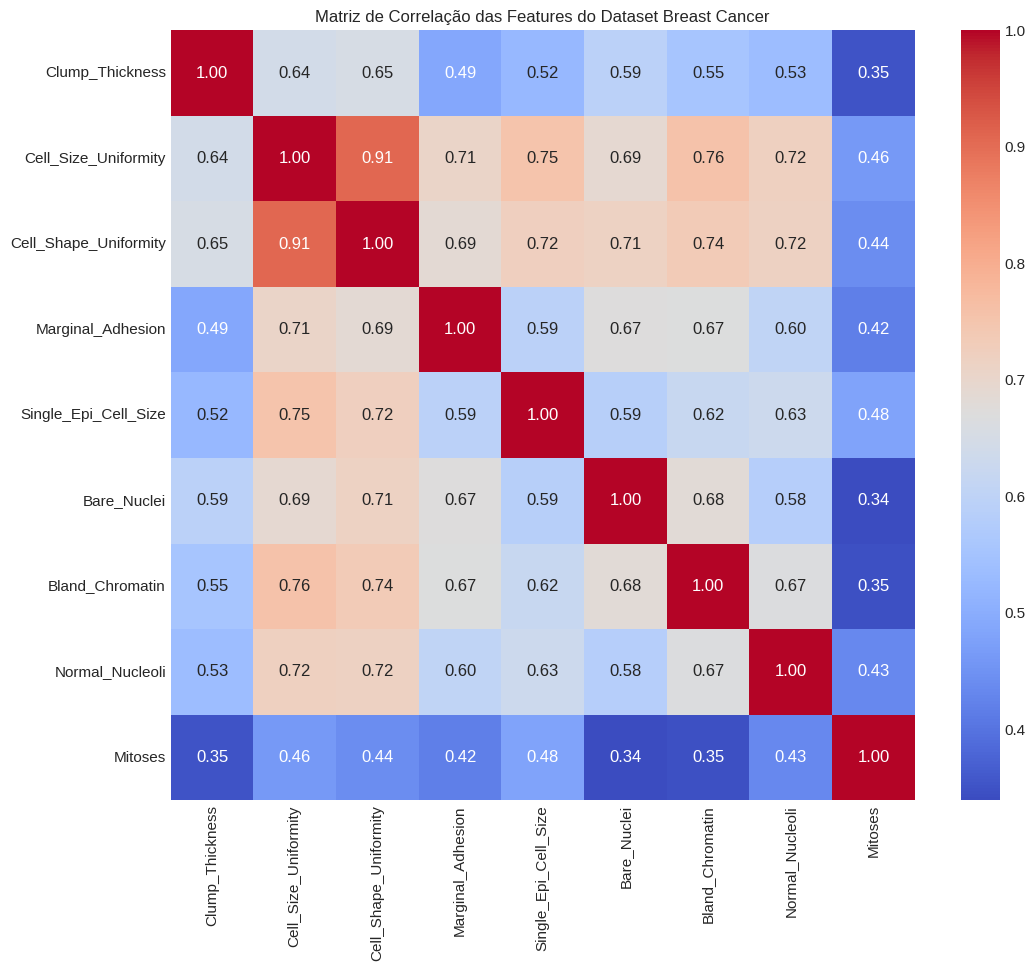

In [40]:
print("Dataset Breast Cancer:")
print(f"Shape: {df_scaled.shape}")
print(f"Features: {X.columns.tolist()}") # Corrected: Use X.columns for feature names
print(f"Classes: {target_names.tolist()}") # Corrected: Use target_names already defined

# 2. Análise das features para seleção
# Recreate breast_df using df_scaled (numpy array) with column names from X
breast_df = pd.DataFrame(df_scaled, columns=X.columns)
correlation_matrix = breast_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Features do Dataset Breast Cancer')
plt.show()

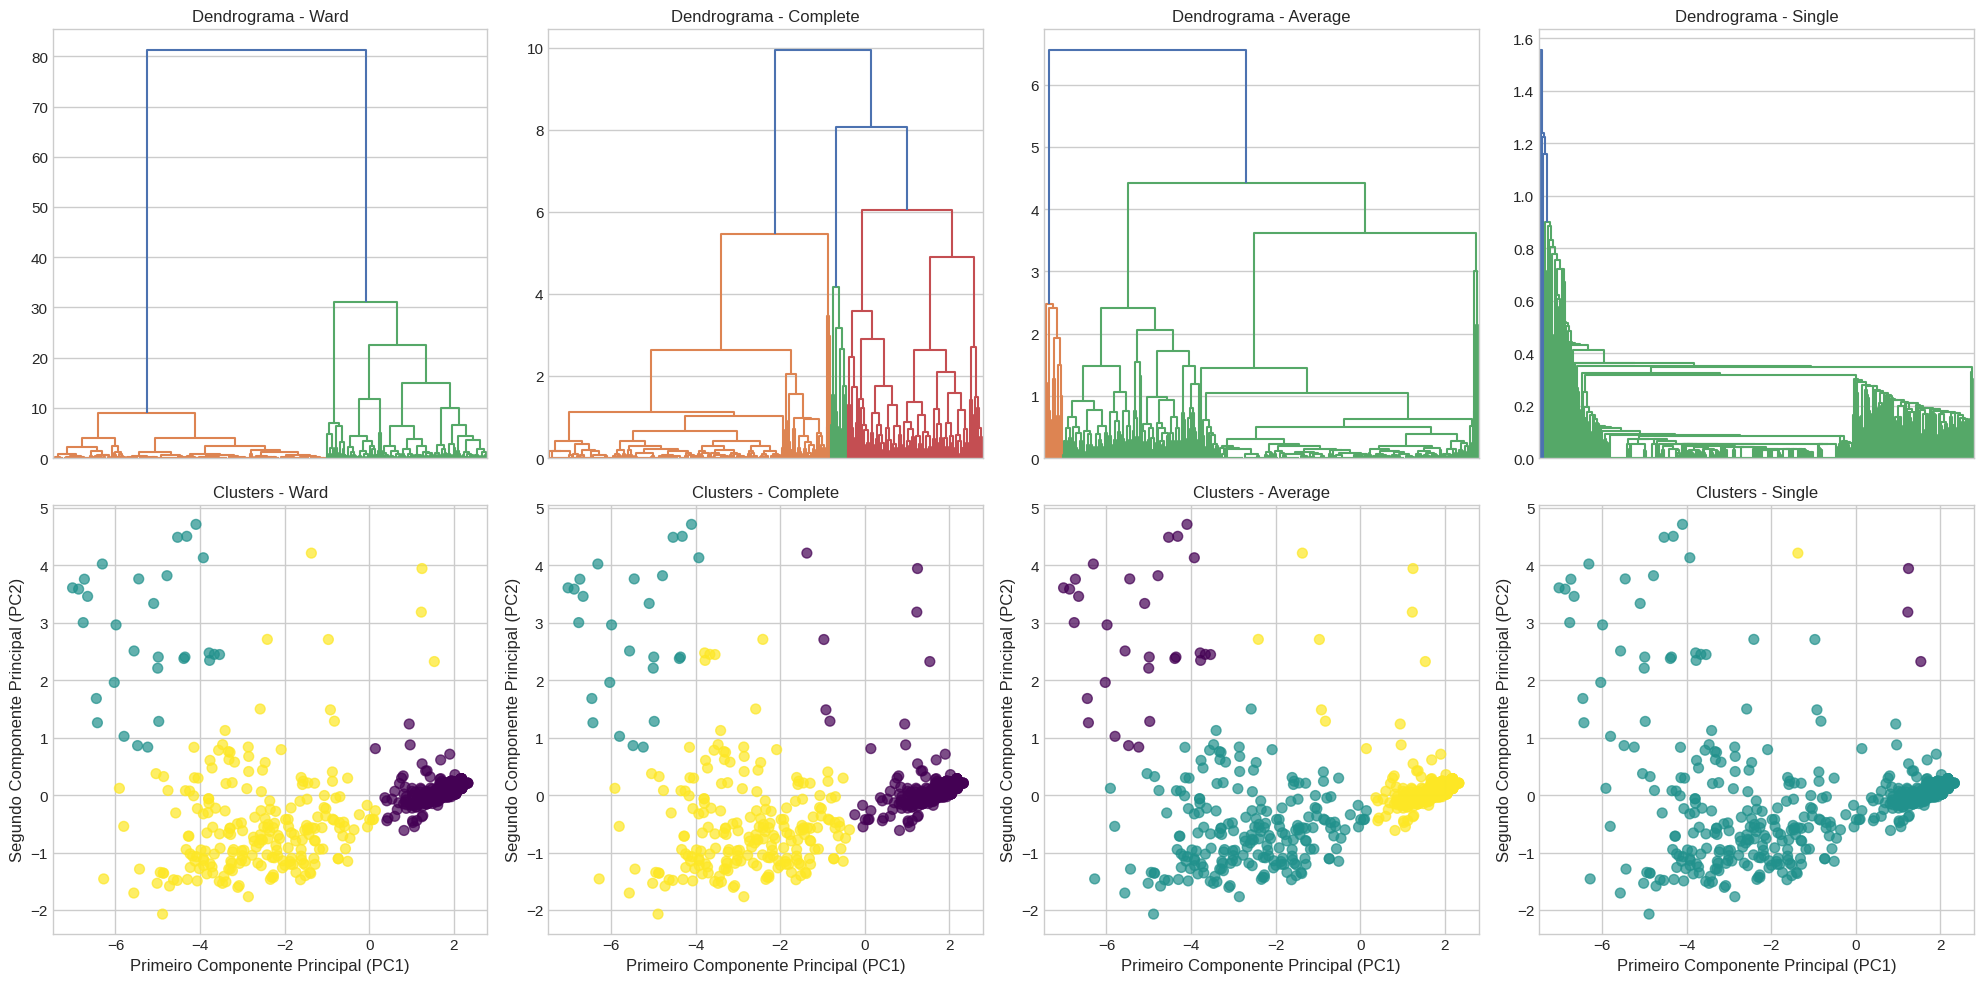

In [42]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Aplicar diferentes métodos de ligação
methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, method in enumerate(methods):
    # Calcular a matriz de ligação usando df_pca (dataset reduzido por PCA)
    linkage_matrix = linkage(df_pca, method=method)

    # Dendrograma
    dendrogram(linkage_matrix, ax=axes[0, i], no_labels=True)
    axes[0, i].set_title(f'Dendrograma - {method.capitalize()}')

    # Obter 3 clusters
    # Os clusters são obtidos do linkage_matrix gerado com df_pca
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

    # Plotar os clusters, usando df_pca para visualização 2D e colorindo pelos clusters encontrados
    scatter = axes[1, i].scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[1, i].set_title(f'Clusters - {method.capitalize()}')
    axes[1, i].set_xlabel('Primeiro Componente Principal (PC1)')
    axes[1, i].set_ylabel('Segundo Componente Principal (PC2)')

plt.tight_layout()
plt.show()

In [45]:
from scipy.stats import mode
import numpy as np

def calculate_purity(y_true, y_pred):
    correct_predictions = 0
    n_samples = len(y_true)

    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)

    return correct_predictions / n_samples

print("Comparação dos métodos de ligação no dataset Breast Cancer:")
print("="*50)
y_true_encoded = y_true.astype('category').cat.codes

for method in methods:
    linkage_matrix = linkage(df_pca, method=method)
    clusters = fcluster(linkage_matrix, 2, criterion='maxclust')
    purity = calculate_purity(y_true_encoded, clusters)
    print(f"{method.capitalize():12} Linkage: {purity:.1%} de acertos")

Comparação dos métodos de ligação no dataset Breast Cancer:
Ward         Linkage: 96.8% de acertos
Complete     Linkage: 96.5% de acertos
Average      Linkage: 69.4% de acertos
Single       Linkage: 65.2% de acertos


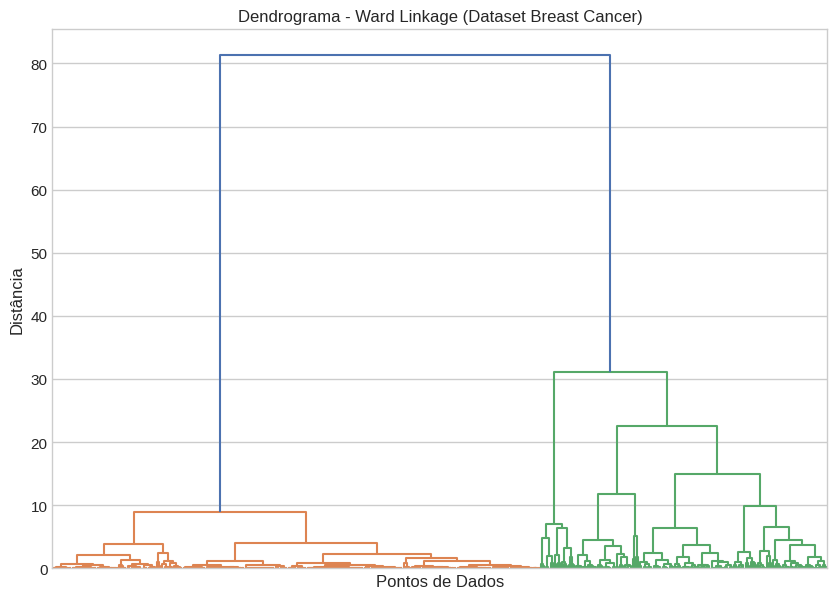

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix_ward = linkage(df_pca, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrograma - Ward Linkage (Dataset Breast Cancer)') # Updated title
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância')
plt.show()

Análise do número ótimo de clusters (Ward Linkage no Dataset Breast Cancer):


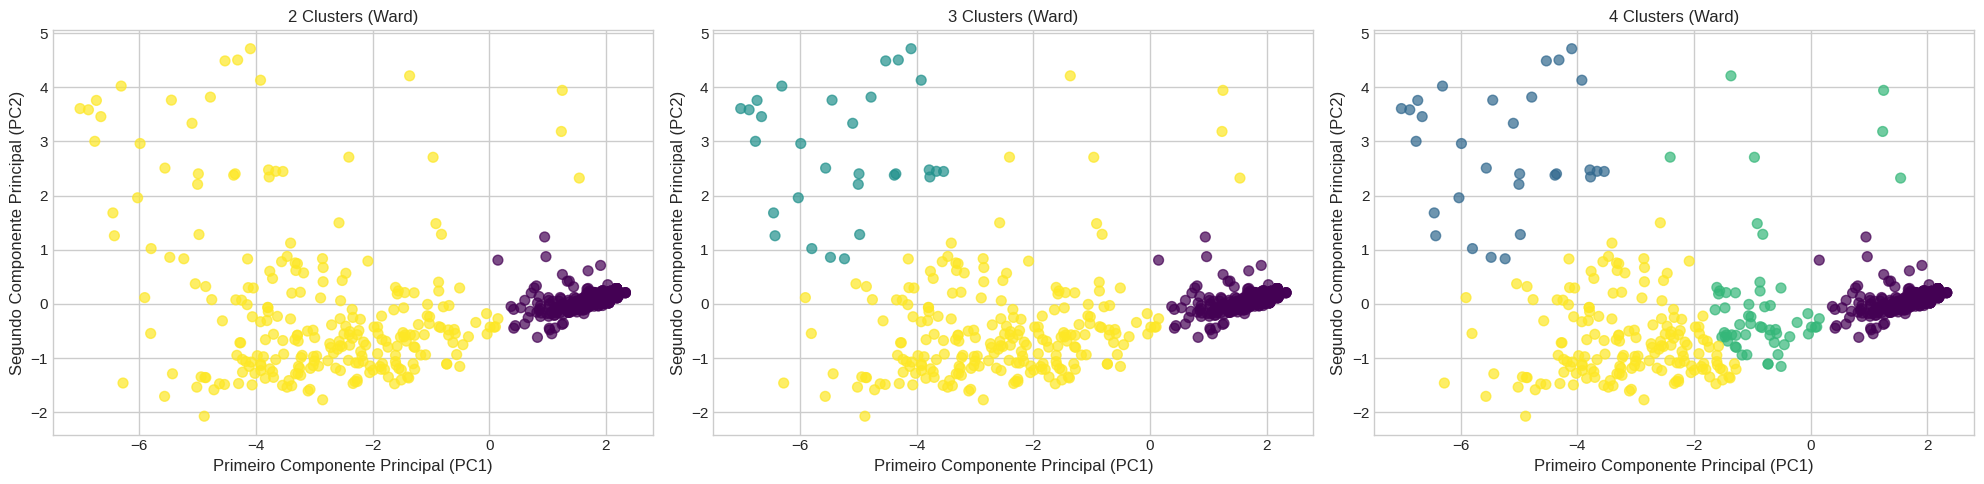

In [57]:
n_clusters_to_test = [2, 3, 4]

print("Análise do número ótimo de clusters (Ward Linkage no Dataset Breast Cancer):")
print("=" * 69)

fig, axes = plt.subplots(1, len(n_clusters_to_test), figsize=(20, 5))

for i, n_clusters in enumerate(n_clusters_to_test):
    clusters = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')

    scatter = axes[i].scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[i].set_title(f'{n_clusters} Clusters (Ward)')
    axes[i].set_xlabel('Primeiro Componente Principal (PC1)')
    axes[i].set_ylabel('Segundo Componente Principal (PC2)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import adjusted_rand_score

for n_clusters in n_clusters_to_test:
    # Obter clusters para o número específico de clusters
    clusters = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')

    # Calcular Pureza
    purity = calculate_purity(y_true_encoded, clusters)

    # Calcular Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(y_true_encoded, clusters)

    print(f"Número de clusters: {n_clusters}")
    print(f"  Pureza: {purity:.3f}")
    print(f"  Adjusted Rand Index (ARI): {ari:.3f}")

Número de clusters: 2
  Pureza: 0.968
  Adjusted Rand Index (ARI): 0.874
Número de clusters: 3
  Pureza: 0.968
  Adjusted Rand Index (ARI): 0.827
Número de clusters: 4
  Pureza: 0.968
  Adjusted Rand Index (ARI): 0.794


A melhor quantidade de Clusters é o 2.

Ambas as purezas então próximos de 1. Entretanto, o ARI diminui sempre que o número de Clusters aumentam.